In [104]:
import numpy as np
import pandas as pd
import os
import pytorch_lightning as pl
import pywt

from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.metrics import f1_score


### Specify model parameters


In [105]:
windowLength = 4 # sample window length, in secs
stride = 0.1  # moving window stride, in secs
overlap = windowLength - stride
ogFs = 5000 # original sampling rate, in Hz
dsFs = 200 # sampling rate, in Hz
nSamples = int(dsFs * windowLength)
nStride = int(dsFs * stride)
nOverlap = int(dsFs * overlap)
fft = True
wavelet = False
if fft:
    nFft = 64 # FFT bin size
else:
    nFft = 1

## Preprocess the BYB 2015 data 

In [106]:
# Create a label encoder
le = LabelEncoder()

# Specify the directory path
directory = '/Users/zhewei/Library/CloudStorage/GoogleDrive-zhewei@umich.edu/My Drive/BYB_EEG_Classfication/Data_Trimmed_200Hz_20s/bundled'

# Read all CSV files in the directory
dataframes = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        # Fit the encoder to the string column and  transform it to numerical data
        df['EyesLabel'] = le.fit_transform(df['EyesLabel'])
        # Normalize the EEG data
        df['EEGdata']= zscore(df['EEGdata'])
        dataframes.append(df)

        # Concatenate all dataframes into a single dataframe
        combined_df = pd.concat(dataframes)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes)

# extract the spectral features from the EEG data
# fft 64 points
feature_df = pd.DataFrame()

for i in range(0, len(combined_df), nSamples - nOverlap):
    # Get the current window
    windowData = combined_df['EEGdata'].iloc[i:i + nSamples]
    wavelet_transform = pywt.wavedec(windowData, 'haar', level=2)

    # Check if the window is of the correct length
    if len(windowData) < nSamples:
        break
    # Compute the spectrogram
    else:
        fft_result = np.fft.fft(windowData, n=nFft)
        fft_result = np.abs(fft_result) 
        # now that every window has 64 spectral features
        # we want to give each of them a column name
        feature_df.loc[i, 'EyesLabel'] = combined_df['EyesLabel'].iloc[i]
        for j in range(nFft):
            feature_df.loc[i, f'fft_{j}'] = fft_result[j]

# zero pad the feature_df
feature_df = feature_df.fillna(0)

## Visualize the data going in the model
## Plot the features against the labels 

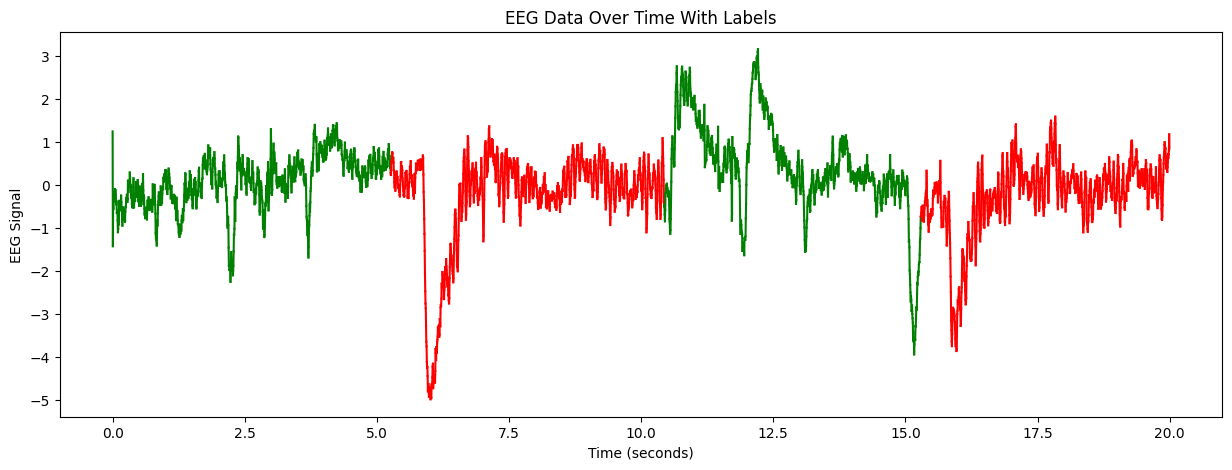

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data and labels have been loaded correctly:
timelength2plot = 20  # Time length to plot in seconds
time = np.arange(0, timelength2plot, 1 / dsFs)

rawData = combined_df['EEGdata'][:timelength2plot * dsFs]
labels = combined_df['EyesLabel'][:timelength2plot * dsFs]
labels = labels.astype(int)

# Create the plot
plt.figure(figsize=(15, 5))
# plt.plot(time, rawData, label='EEG Data', color='gray', alpha=0.5)

# Using fill_between to show non-overlapping segments
# plt.fill_between(time, rawData, where=labels == 1, interpolate=True, color='green', alpha=0.3, label='Eyes Open')
# plt.fill_between(time, rawData, where=labels == 0, interpolate=True, color='red', alpha=0.3, label='Eyes Closed')
# Plot the EEG data with color based on the label
for i in range(1, len(time)):
    if labels[i] == 1:  # Eyes open
        plt.plot(time[i-1:i+1], rawData[i-1:i+1], color='green', label='Eyes Open')
    else:  # Eyes closed
        plt.plot(time[i-1:i+1], rawData[i-1:i+1], color='red', label='Eyes Closed')


plt.xlabel('Time (seconds)')
plt.ylabel('EEG Signal')
plt.title('EEG Data Over Time With Labels')
#put legend within the plots north east corner
plt.show()





# Define the sample rate and the low and high cut frequencies for the alpha band



## Plot alpha band filtered data for inspection 

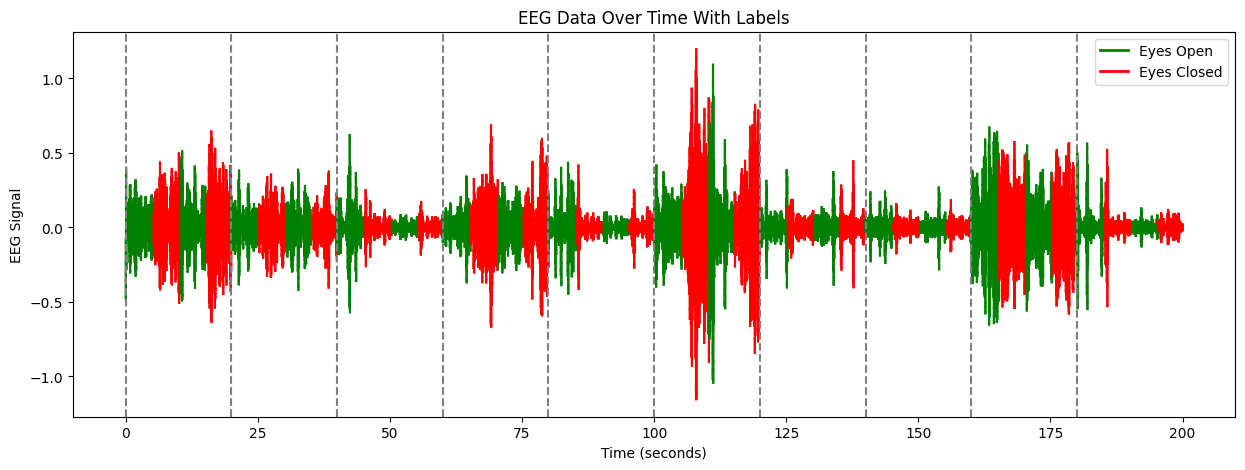

In [108]:
# make a second plot with the filtered data 
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut = 8.0  # Alpha band starts at 8 Hz
highcut = 12.0  # Alpha band ends at 12 Hz
fs = 200  # Sample rate is 200 Hz
order = 2  # Order of the filter

timelength2plot = 200  # Time length to plot in seconds
rawData = combined_df['EEGdata'][:timelength2plot * dsFs]
filteredData = butter_bandpass_filter(rawData, lowcut, highcut, fs, order=order)
labels = combined_df['EyesLabel'][:timelength2plot * dsFs]
time = np.arange(0, timelength2plot, 1 / dsFs)

# Create the plot
plt.figure(figsize=(15, 5))

# Create the plot
for i in range(1, len(time)):
    if labels.iloc[i] == 1:  # Eyes open
        plt.plot(time[i-1:i+1], filteredData[i-1:i+1], color='green', label='Eyes Open')
    else:  # Eyes closed
        plt.plot(time[i-1:i+1], filteredData[i-1:i+1], color='red', label='Eyes Closed')

# id also like to add a dashed vertical line every 20 seconds time wise
for i in range(0, timelength2plot, 20):
    plt.axvline(x=i, color='gray', linestyle='--')

# Create custom legend
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, ['Eyes Open', 'Eyes Closed'])

plt.xlabel('Time (seconds)')
plt.ylabel('EEG Signal')
plt.title('EEG Data Over Time With Labels')
#put legend within the plots north east corner
plt.show()

## Plot the alpha band power for inspection

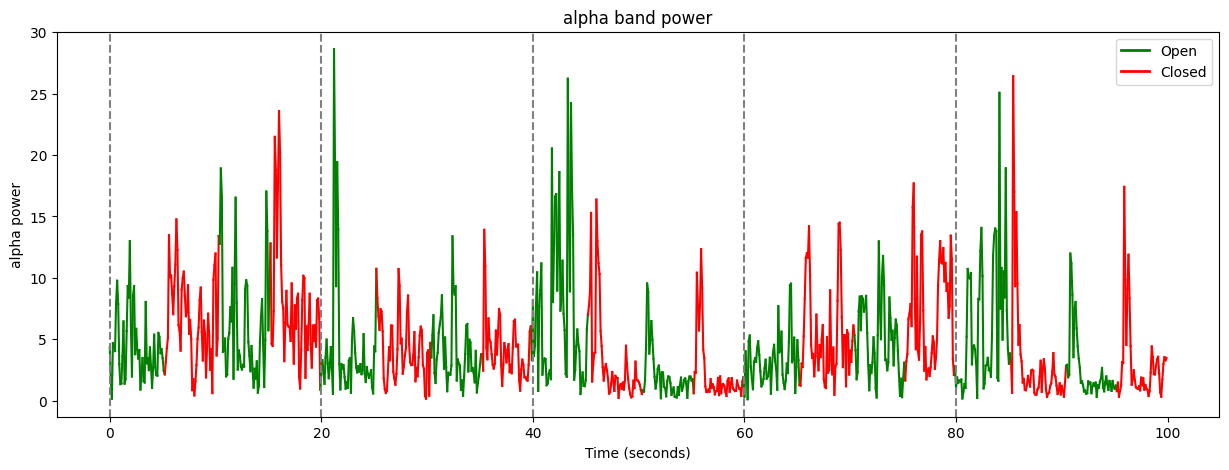

In [109]:
# get the alpha band power from the fft results 
# This is how we acquired the fft valyes fft_result = np.fft.fft(windowData, n=nFft)
# i only care about the 8 -12 hz 
nFft = 64
dsFs = 200
# Calculate the frequencies for each FFT bin  # Size of the FFT
freqs = np.fft.fftfreq(nFft, 1/dsFs)

# Find the bins that fall within the 8-12 Hz range
alpha_bins = np.where((freqs >= 8) & (freqs <= 12))

# get the corresponding columns from the feature_df
alpha_power = feature_df[[f'fft_{i}' for i in alpha_bins[0]]]

# set the time series for this plot 
timelength2plot = 100  # Time length to plot in seconds
# for alpha power computing, we extracted windows of 2 seconds, and stride of 0.5 seconds
time = np.arange(0, timelength2plot, stride)
labels = feature_df['EyesLabel'][:len(time)]
alpha_power = alpha_power[:len(time)]

assert len(alpha_power) == len(time)
assert len(labels) == len(time)

# Create the plot
plt.figure(figsize=(15, 5))

# Create the plot
for i in range(0, len(time)):
    if labels.iloc[i] == 1:  # Eyes open
        plt.plot(time[i-1:i+1], alpha_power[i-1:i+1], color='green')
    else:  # Eyes closed
        plt.plot(time[i-1:i+1], alpha_power[i-1:i+1], color='red')

# id also like to add a dashed vertical line every 20 seconds time wise
for i in range(0, timelength2plot, 20):
    plt.axvline(x=i, color='gray', linestyle='--')

# Create custom legend
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='red', lw=2)]



plt.legend(custom_lines, ['Open', 'Closed'])

plt.xlabel('Time (seconds)')
plt.ylabel('alpha power')
plt.title('alpha band power')
#put legend within the plots north east corner
plt.show()

# yes, no, no, yes(?), no


## Split into train, validation, and test datasets

In [110]:
# Split the data into train and test sets
train_df, test_df = train_test_split(feature_df, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Print the shapes of the train, test, and validation sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Validation set shape:", val_df.shape)

Train set shape: (9958, 65)
Test set shape: (3113, 65)
Validation set shape: (2490, 65)


## define the fully connected model here 

In [111]:
class FCModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate):
        super(FCModel, self).__init__()
        # input layer that formats the input data
        self.preds = []
        self.y = []
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        self.log('val_loss', loss)

         # Calculate F1 score
        _, preds = torch.max(y_hat, dim=1)
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log('val_f1', f1)

        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        self.log('test_loss', loss)

        # Calculate accuracy
        _, preds = torch.max(y_hat, dim=1)
        acc = torch.sum(y == preds).item() / (len(y) * 1.0)
        self.log('test_acc', acc)

        # Save predictions and labels
        self.preds.append(preds)
        self.y.append(y)

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels
        self.preds = torch.cat(self.preds, dim=0)
        self.y = torch.cat(self.y, dim=0)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Specify the input size, hidden sizes, output size, and dropout rate
# Define the train_dataloader variable and assign it with the appropriate data loader object
# Create an instance of the pl.Trainer class
# Instantiate an object of the FCModel class and assign it to the model variable

# the input feature is the 64 fft features 

input_size = nFft
hidden_size1 = 40
hidden_size2 = 20
output_size = 1
dropout_rate = 0.25

# Assemble the model
model = FCModel(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
# print out model 
print(model)
trainer = pl.Trainer(max_epochs=100)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCModel(
  (fc1): Linear(in_features=64, out_features=40, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


## Train the model and use validation to tune the hyper-parameters

In [112]:
# Separate features and labels
features = train_df.iloc[:, 1:].values.astype(np.float32)  # all columns except the first one
labels = train_df.iloc[:, 0].values.astype(np.float32)  # only the first column

# Convert to Tensors
features = torch.tensor(features)
labels = torch.tensor(labels)
# Create a TensorDataset
train_dataset = torch.utils.data.TensorDataset(features, labels)

# Create a DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True)


# Separate features and labels
val_features = val_df.iloc[:, 1:].values.astype(np.float32)  # all columns except the first one
val_features = torch.tensor(val_features)
val_labels = val_df.iloc[:, 0].values.astype(np.float32)  # only the first column
val_labels = torch.tensor(val_labels)
val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True)


# Define the early stopping callback
early_stop_callback = EarlyStopping(
   monitor='val_f1',
   min_delta=0.00,
   patience=10,
   verbose=False,
   mode='max'  # Change to 'max' because we want to maximize accuracy
)

# Create the trainer
trainer = Trainer(callbacks=[early_stop_callback])

trainer = Trainer(max_epochs=100)
# Train the model
trainer.fit(model, train_dataloader, val_dataloader)

# Validate the model
trainer.validate(model, val_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 2.6 K 
1 | relu1   | ReLU    | 0     
2 | dropout | Dropout | 0     
3 | fc2     | Linear  | 820   
4 | relu2   | ReLU    | 0     
5 | fc3     | Linear  | 21    
------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 312/312 [00:02<00:00, 149.72it/s, v_num=66]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Validation DataLoader 0: 100%|██████████| 78/78 [00:00<00:00, 195.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.33469492197036743
        val_loss                    0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.0, 'val_f1': 0.33469492197036743}]

## Test the trained model on held out testing data

In [113]:
# now that the trainer is fitted
# we can evaluate the model on the validation set
# Convert DataFrame to Tensor

test_features = test_df.iloc[:, 1:].values.astype(np.float32)  # all columns except the first one
test_labels = test_df.iloc[:, 0].values.astype(np.float32)  # only the first column

# Convert to Tensors
test_features = torch.tensor(test_features)
test_labels = torch.tensor(test_labels)

# Create a TensorDataset
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

# Create a DataLoader from the TensorDataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

trainer.test(model, test_dataloader)
print(model.preds)
print(model.y)


/Users/zhewei/Library/CloudStorage/GoogleDrive-zhewei@umich.edu/My Drive/BYB_EEG_Classfication/workspace/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 256.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.49726951122283936
        test_loss                   0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
tensor([0, 0, 0,  ..., 0, 0, 0], device='mps:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='mps:0')


## Visualize the test set prediction results

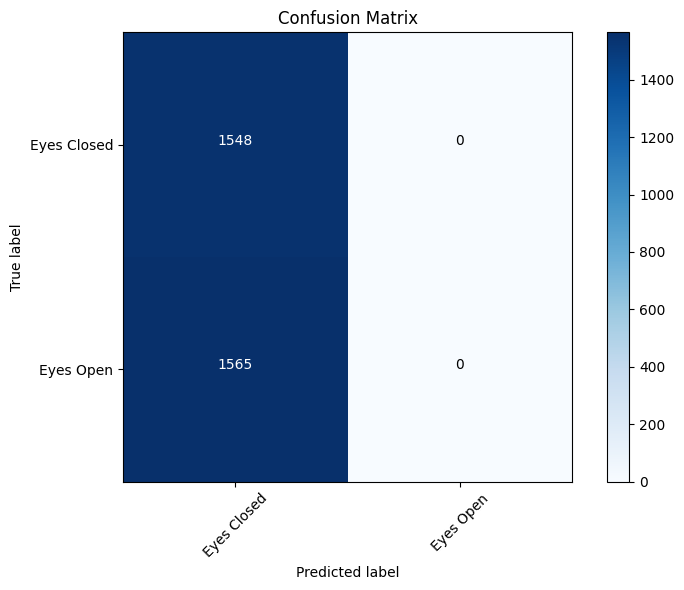

In [114]:
# i want to visualize the model's performance on the test set
# so i will create a confusion matrix
# and a classification report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have the predicted labels and true labels for the test set
true_labels = test_labels.numpy()

# Compute the confusion matrix
cm = confusion_matrix(true_labels, model.preds.cpu().numpy())
# Define class labels
class_labels = ['Eyes Closed', 'Eyes Open']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## export the weights from the trained network

In [115]:
# export the model weights
torch.save(model.state_dict(), 'model_weights.pth')

## GRU network setup

In [116]:
from torch.utils.data import DataLoader
from torch import optim
import torchmetrics

# Step 1: Define the GRU network architecture
class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,dropout=0.5):
        super(GRUNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hidden = self.gru(x)
        last_hidden_state = hidden[-1]  
        output = self.fc(last_hidden_state)
        output = self.sigmoid(output)
        return output

# Define the input size, hidden size, and output size
input_size = nFft  # Assuming one feature (EEGData) as input
hidden_size = 50  # Number of hidden units in the GRU layer
batch_size = 32  # Number of samples in each batch
output_size = batch_size  # Number of output units (labels)

# Create an instance of the GRU network
gru_net = GRUNetwork(input_size, hidden_size, output_size)

# Print the network architecture
print(gru_net)

# Step 2: Prepare the data
# Create PyTorch DataLoader objects for each set

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4,persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4,persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4,persistent_workers=True)

# Step 3: Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 100

model = GRUNetwork(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

# Metrics
accuracy = torchmetrics.Accuracy(task='binary',threshold=0.5).to(device)
f1_score = torchmetrics.F1Score(task='binary',threshold=0.5).to(device)


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for inputs,labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        if len(labels) != batch_size or len(inputs) != batch_size:
            continue

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        # Update metrics
        accuracy.update(outputs, labels.float())
        f1_score.update(outputs, labels.float())

    # Log epoch metrics
    train_acc = accuracy.compute()
    train_f1 = f1_score.compute()
    print(f"Epoch {epoch+1}: Loss: {loss.item()}, Accuracy: {train_acc}, F1 Score: {train_f1}")

    # Reset metrics for next epoch
    accuracy.reset()
    f1_score.reset()

# Evaluation loop
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        if len(labels) != batch_size or len(inputs) != batch_size:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Update metrics
        accuracy.update(outputs, labels.float())
        f1_score.update(outputs, labels.float())

test_acc = accuracy.compute()
test_f1 = f1_score.compute()
print(f"Test Accuracy: {test_acc}, Test F1 Score: {test_f1}")
 

GRUNetwork(
  (gru): GRU(64, 50, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=50, out_features=32, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1: Loss: 0.743700385093689, Accuracy: 0.5078375935554504, F1 Score: 0.5234481692314148
Epoch 2: Loss: 0.7285161018371582, Accuracy: 0.5182877779006958, F1 Score: 0.5457646250724792
Epoch 3: Loss: 0.725211501121521, Accuracy: 0.5404943823814392, F1 Score: 0.5687069892883301
Epoch 4: Loss: 0.70875483751297, Accuracy: 0.5586816668510437, F1 Score: 0.5856603980064392
Epoch 5: Loss: 0.6775527596473694, Accuracy: 0.575160801410675, F1 Score: 0.6031537652015686
Epoch 6: Loss: 0.6622342467308044, Accuracy: 0.5926446914672852, F1 Score: 0.6186982989311218
Epoch 7: Loss: 0.6439329385757446, Accuracy: 0.6088223457336426, F1 Score: 0.6306101083755493
Epoch 8: Loss: 0.6272980570793152, Accuracy: 0.6261053085327148, F1 Score: 0.6475324630737305
Epoch 9: Loss: 0.606756329536438, Accuracy: 0.6425843834877014, F1 Score: 0

KeyboardInterrupt: 